# <h1 align= 'center'>Base Models</h1>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from scipy.stats import uniform
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## <h2> <center>Load preprocessed data</center></h2>

In [3]:
# for importing data to colab
from google.colab import drive 
drive.mount('/content/drive')

movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cleaned_data.csv')
movies.sample(7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,review,sentiment
24052,24052,understand go could various way continu line d...,1
21737,21737,warm sweet remark charm two antagonist worker ...,1
42528,42528,ok rent sever year ago worst expect yes act gr...,1
5418,5418,citi hall somewhat mix bag part vignett nyc po...,1
4406,4406,know mayb mood kind full trite melodrama long ...,0
3081,3081,recal see kid recal saw must around 14 year ol...,1
16813,16813,revolut terribl care histori teacher news writ...,0


In [0]:
# read from local dataset
# movies = pd.read_csv('data/imdb_data.csv')
# movies.sample(7)

## <h2> <center>Text feature extraction</center></h2>

In [5]:
# todo: normalize if overfit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif


top_k = 15000

tfidf = TfidfVectorizer(
                    ngram_range = (1,2),
                    dtype = 'int32',
                    decode_error = 'replace',
                    analyzer = 'word',
                    min_df = 2,
                    norm = 'l2'
                    )
tfidf_reviews = tfidf.fit_transform(movies['review'])

# Select best 10,000(k) features, with feature importance measured by f_classif
selector = SelectKBest(f_classif, k = min(top_k, tfidf_reviews.shape[1]))
selector.fit(tfidf_reviews, movies['sentiment'])
vect_reviews = selector.transform(tfidf_reviews).astype('float32')

vect_reviews.shape

(50000, 15000)

## <h2> <center>Split the data</center></h2>

In [6]:
X = vect_reviews.toarray()
y = (np.array(movies['sentiment']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")

Train dataset shape: (40000, 15000), 
Test dataset shape: (10000, 15000)


In [0]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names  = ['Positive', 'Negative'], vmax=None,
                           normalized=True, title='Confusion matrix'):
    """
    Helper fuction to generate a clean Confusion Matrix using seaborn library.
    y_true: True labels, y_pred: Model Predictions, class_names: Override if needed
    normalized: True, gives the proportions instead of absolute numbers
    """
    matrix = confusion_matrix(y_true,y_pred)
    if normalized:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    annot_kws = {'fontsize':25, 
                'fontstyle': 'italic'}
    sns.heatmap(matrix, vmax=vmax, annot=True,  annot_kws = annot_kws,
                square=True, ax=ax, cbar=False,
                cmap=sns.diverging_palette(20, 250, as_cmap=True), 
                linecolor='black', linewidths=0.5,
                xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

## <h2> <center>Modeling the data</center></h2>

### <h2> <center>Base Logistic Regression model</center></h2>

In [8]:
lr=LogisticRegression(max_iter=500 ,random_state=7, 
                      C = 10, penalty = 'l2') # found from Random Search 
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
pred = lr.predict(X_test)
pred_train = lr.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  93.8425
Test set Accuracy:  90.79


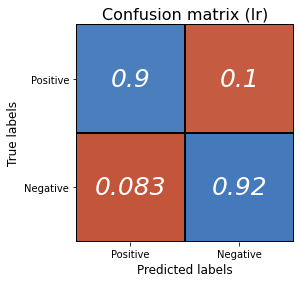

In [10]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (lr)')

In [11]:
penalty = ['l2', 'l1']
# Create regularization hyperparameter distribution using uniform distribution
C = [0.1, 10, 100]
logistic = LogisticRegression()
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
pprint(hyperparameters)
lr_best = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy',
                       cv = 2, verbose = 0, refit=True, return_train_score = True)

{'C': [0.1, 10, 100], 'penalty': ['l2', 'l1']}


In [12]:
lr_best.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 10, 100], 'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [13]:
lr_best_penalty = lr_best.best_estimator_.get_params()['penalty']
lr_best_c = lr_best.best_estimator_.get_params()['C']
print(f'Best Penalty: {lr_best_penalty}')
print(f'Best C: {lr_best_c}')

pprint(lr_best.best_params_)

Best Penalty: l2
Best C: 10
{'C': 10, 'penalty': 'l2'}


In [14]:
pred = lr_best.predict(X_test)
pred_train = lr_best.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  93.8425
Test set Accuracy:  90.79


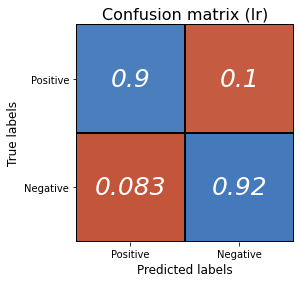

In [15]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (lr)')

### <h2> <center>SVM Classifier</center></h2>

In [16]:
svm = SGDClassifier(random_state = 7, penalty = 'l2', loss = 'hinge')

svm.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=7, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
pred = svm.predict(X_test)
pred_train = svm.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  89.8475
Test set Accuracy:  89.13


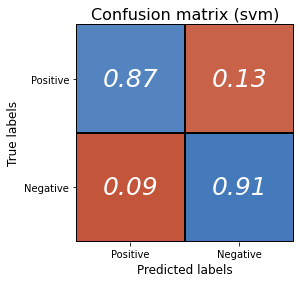

In [18]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (svm)',
                       class_names=['Positive', 'Negative'])

### <h2> <center>Linear SVC</center></h2>

In [19]:
svc = LinearSVC(random_state = 7)
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
          verbose=0)

In [20]:
pred = svc.predict(X_test)
pred_train = svc.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  94.08999999999999
Test set Accuracy:  91.08000000000001


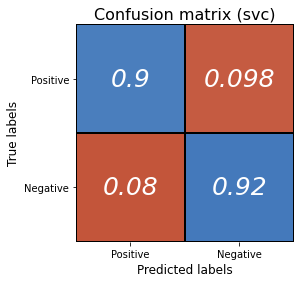

In [21]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (svc)',
                       class_names=['Positive', 'Negative'])

In [22]:
losses = ["hinge", "squared_hinge"]
duals = [False, True]
learning_rates = [1e-1, 1, 10]
penalties = ["l1", "l2"]

hyperparam = {
    "C": learning_rates,
    "penalty": penalties,
    "loss": losses,
    "dual": duals
    }
pprint(hyperparam)
svc = LinearSVC()

n_iter = 50
svc_random = RandomizedSearchCV(svc, hyperparam, cv=2, scoring = 'accuracy',
                                verbose=0, refit = True)

{'C': [0.1, 1, 10],
 'dual': [False, True],
 'loss': ['hinge', 'squared_hinge'],
 'penalty': ['l1', 'l2']}


In [23]:
svc_random.fit(X_train, y_train)

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                       fit_intercept=True, intercept_scaling=1,
                                       loss='squared_hinge', max_iter=1000,
                                       multi_class='ovr', penalty='l2',
                                       random_state=None, tol=0.0001,
                                       verbose=0),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 1, 10],
                                        'dual': [False, True],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=0)

In [24]:
pprint(svc_random.best_params_)

{'C': 1, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'}


In [25]:
pred = svc_random.predict(X_test)
pred_train = svc_random.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  91.945
Test set Accuracy:  90.23


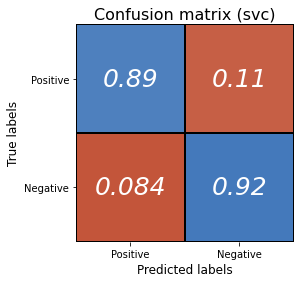

In [26]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (svc)',
                       class_names=['Positive', 'Negative'])

### <h2> <center>Multinomial Bayes Classifier</center></h2>

In [27]:
#training the model
mnb = MultinomialNB(alpha = 0.001) # best alpha found from Grid Search
#fitting the svm for bag of words
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [28]:
pred = mnb.predict(X_test)
pred_train = mnb.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  92.44
Test set Accuracy:  91.32000000000001


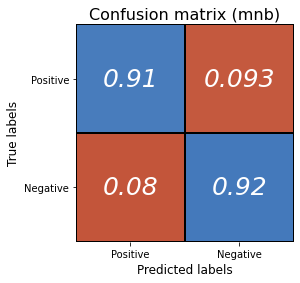

In [29]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (mnb)')

In [30]:
alpha =  [0.001, 0.003, 0.1, 0.3, 1]
hyperparam = dict(alpha = alpha)
mnb_best = GridSearchCV(mnb, hyperparam, scoring = 'accuracy', cv = 2, refit = True, verbose = 1, return_train_score = True)
pprint(hyperparam)

{'alpha': [0.001, 0.003, 0.1, 0.3, 1]}


In [31]:
mnb_best.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   47.0s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=MultinomialNB(alpha=0.001, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.001, 0.003, 0.1, 0.3, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [32]:
mnb_best_alpha = mnb_best.best_estimator_.get_params()['alpha']
print(f'Best alpha: {mnb_best_alpha}')

Best alpha: 0.001


In [34]:
pred = mnb_best.predict(X_test)
pred_train = mnb_best.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  92.44
Test set Accuracy:  91.32000000000001


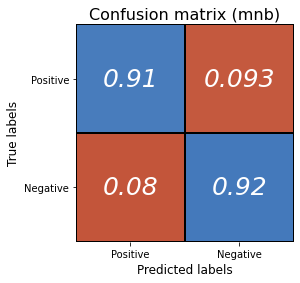

In [35]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (mnb)')

### <h2> <center>Random Forest Classifier</center></h2>

In [0]:
# takes a lot of time ...
rf = RandomForestClassifier(max_depth = 100, 
                            n_estimators = 500,
                            min_samples_leaf = 5,
                            min_samples_split = 2,
                            max_features = 'sqrt',
                            random_state = 7)  # found from Random Search

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [0]:
pred = rf.predict(X_test)
pred_train = rf.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  95.2325
Test set Accuracy:  85.87


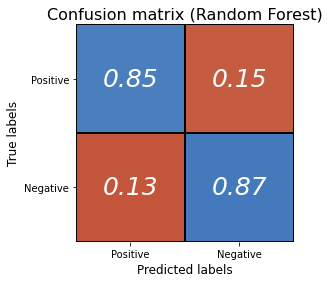

In [0]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, pred, ax=axis1,
                       title='Confusion matrix (Random Forest)',
                       class_names=['Positive', 'Negative'])

In [0]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

hyperparam = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(hyperparam)
rf_temp = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf_temp, hyperparam, cv = 2, n_iter = 10, verbose = 1,
                        refit = False, return_train_score = True)

{'max_depth': [10, 55, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 550, 1000]}


In [0]:
# takes a lot of time ...
# rf_random.fit(X_train, y_train)

In [0]:
# pprint(rf_random.best_params_)

* The models that performed the best Multinomial Naive Bayes and Support Vector Machine
* Random forest seems to be overfitting and is obviously not suited to this task.